# Coronavirus - Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, re, pickle

from pydemic import Pandemic, Outbreak

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams['figure.figsize']=[32,18]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

plt.style.use('seaborn-whitegrid')

In [3]:
# %reload_ext autoreload
# %autoreload 2
%matplotlib inline

## Construct Pandemic

In [4]:
coronavirus_confirmed_df = pd.read_csv("../data/clean/coronavirus_confirmed_global.csv", index_col=0)
coronavirus_death_df = pd.read_csv("../data/clean/coronavirus_death_global.csv", index_col=0)
coronavirus_recovered_df = pd.read_csv("../data/clean/coronavirus_recovered_global.csv", index_col=0)
coronavirus_advanced_testing_policy_adopted = pd.read_csv("../data/clean/coronavirus_advanced_testing_policy_adopted.csv", index_col=0, squeeze=True)
coronavirus_latest_testing_per_thousand = pd.read_csv("../data/clean/coronavirus_latest_testing_per_thousand.csv", index_col=0, squeeze=True)

pandemic = Pandemic(
    "Coronavirus", 
    coronavirus_confirmed_df, 
    coronavirus_death_df, 
    recovery_curve=coronavirus_recovered_df, 
    advanced_testing_policy_adopted=coronavirus_advanced_testing_policy_adopted,
    latest_testing_per_thousand=coronavirus_latest_testing_per_thousand
)

### Save Outbreaks

In [5]:
for outbreak in pandemic.outbreaks.values():
    outbreak.to_csv()

## Analyze Data

In [335]:
def plot_outbreaks(outbreaks):
    fig, axes = plt.subplots(nrows=2)

    axes[0].set_title("Daily Cases")
    axes[1].set_title("Daily Deaths")

    for (region, outbreak) in outbreaks.items():
        sns.lineplot(data=outbreak.epidemic_curve.values, label=region, ax=axes[0])
        sns.lineplot(data=outbreak.fatality_curve.values, label=region, ax=axes[1])

    plt.show()

### Top Affected Regions

We have data available on 185 different regions (mostly representing countries). Of course, for a preliminary analysis, we don't want to necessarily consider all of these. We will therefore take a subset of top affected countries that represent a large enough coverage of the global pandemic. As of today (22 of April), the top 10 affected countries represent 2/3 of cases and 3/4ths of deaths. We consider this to be representative enough for the preliminary analysis and will proceed with this truncated dataset.

Regions: US, Russia, United Kingdom, Spain, Italy, Brazil, France, Germany, Turkey, Iran
Case coverage=71.61
Death coverage=79.65
Recovery coverage=66.06


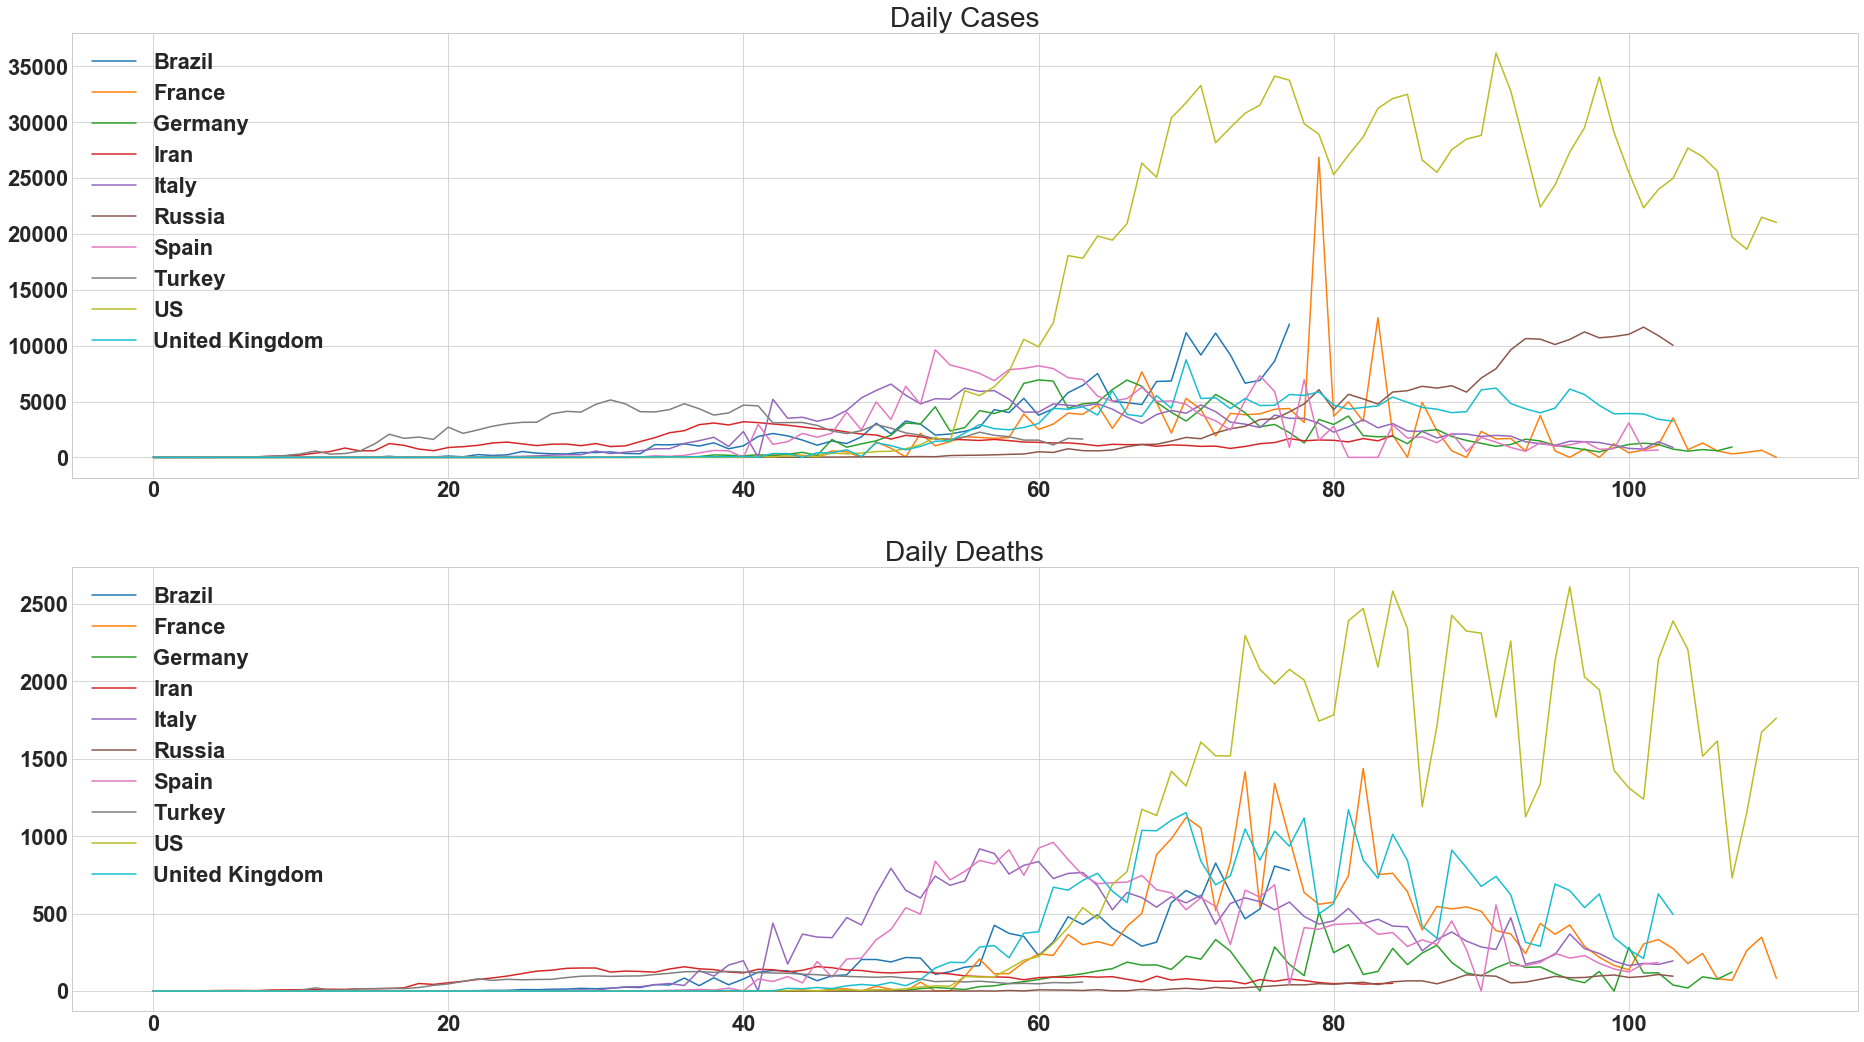

In [370]:
top10_countries = pandemic.get_top_regions(top_n=10)
top10_outbreaks = pandemic.get_outbreaks(top10_countries)

pandemic.print_regions_coverage(top10_countries)
plot_outbreaks(top10_outbreaks)

In [371]:
top20_countries = pandemic.get_top_regions(top_n=20)
top20_outbreaks = pandemic.get_outbreaks(top20_countries)

pandemic.print_regions_coverage(top20_countries)

Regions: US, Russia, United Kingdom, Spain, Italy, Brazil, France, Germany, Turkey, Iran, China, India, Peru, Canada, Belgium, Saudi Arabia, Netherlands, Mexico, Pakistan, Chile
Case coverage=84.58
Death coverage=91.36
Recovery coverage=82.04


In [372]:
top50_countries = pandemic.get_top_regions(top_n=50)
top50_outbreaks = pandemic.get_outbreaks(top50_countries)

pandemic.print_regions_coverage(top50_countries)

Regions: US, Russia, United Kingdom, Spain, Italy, Brazil, France, Germany, Turkey, Iran, China, India, Peru, Canada, Belgium, Saudi Arabia, Netherlands, Mexico, Pakistan, Chile, Ecuador, Switzerland, Portugal, Sweden, Qatar, Belarus, Singapore, Ireland, United Arab Emirates, Bangladesh, Poland, Israel, Ukraine, Japan, Romania, Austria, Indonesia, Colombia, South Africa, Philippines, Dominican Republic, Kuwait, Korea, South, Denmark, Egypt, Serbia, Panama, Czechia, Norway, Australia
Case coverage=96.17
Death coverage=98.21
Recovery coverage=94.93


## Oubtreak Peaks

In [434]:
def plot_peaks(regions, filepath=None):
    n_regions = len(regions)
    n_rows = int(np.ceil(n_regions / 2))
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(32, 8 * n_regions / 2))
    
    for i, (region, outbreak) in enumerate(pandemic.get_outbreaks(regions).items()):
        ax = axes[i // 2][i % 2]
        ax.set_title(outbreak.region)

        sns.lineplot(data=outbreak.fatality_curve.values, ax=ax)
        if outbreak.is_peak_reached():
            ax.vlines(outbreak.get_peak_id(), ymin=0, ymax=outbreak.fatality_curve[outbreak.get_peak_id()], colors=['red'], linestyles=['dashed'], label=["detected peak"])
        
    fig.subplots_adjust(hspace=0.5)
    
    if filepath is not None:
        plt.savefig(filepath)
        
    plt.show()

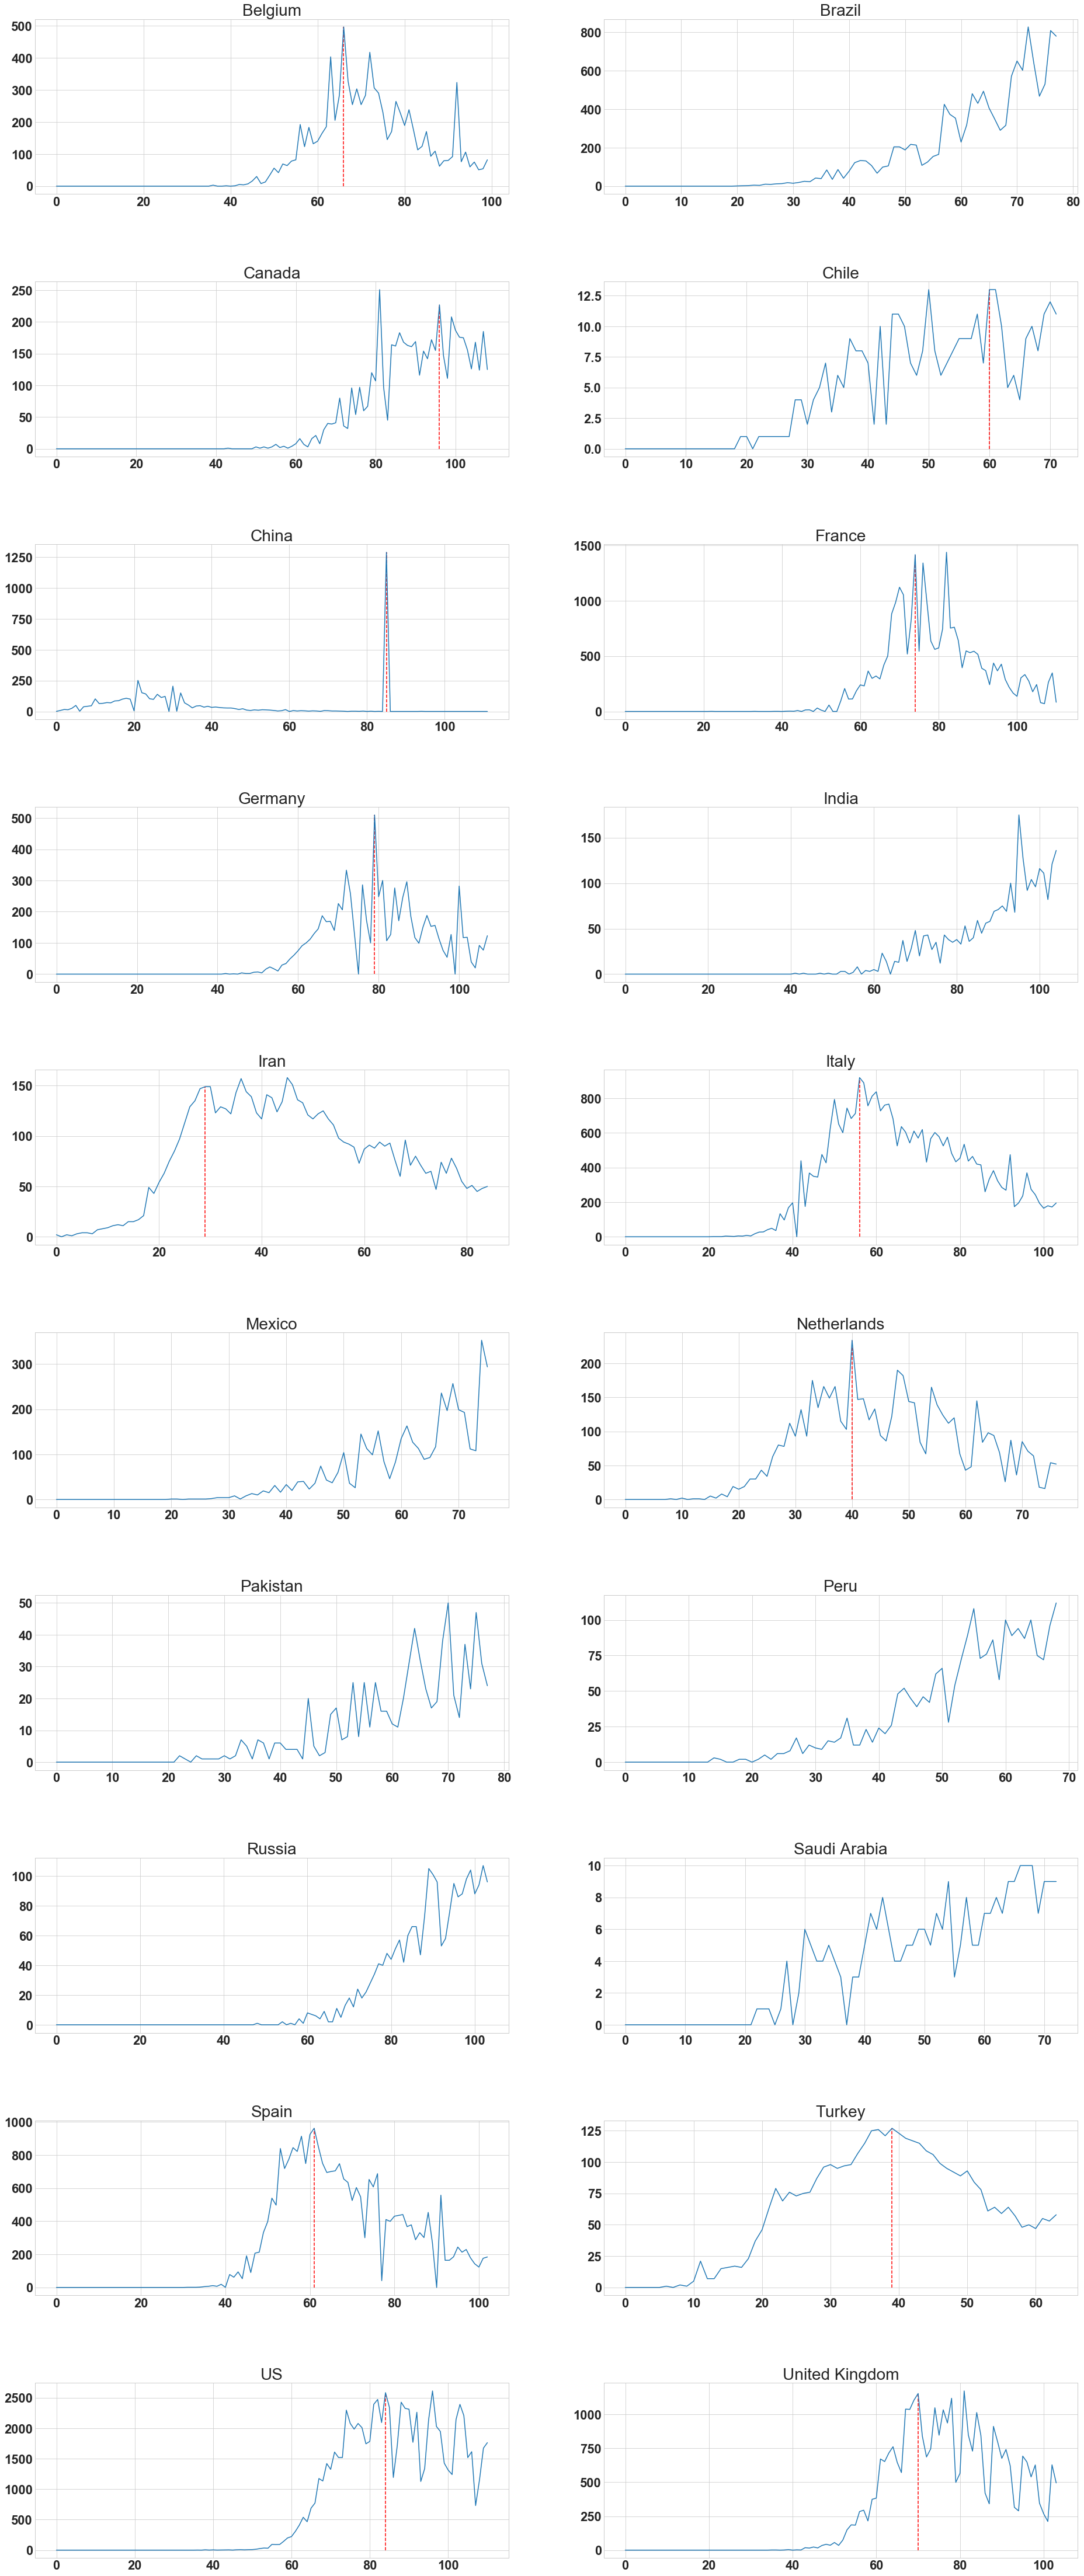

In [415]:
plot_peaks(top20_countries, filepath="../plots/coronavirus/top20country_peaks.pdf")

## Testing-based Outbreak Selection for Basis Formation

In [439]:
selected_regions = set([])

total_fatality_threshold = 1000
testing_threshold = pandemic.latest_testing_per_thousand.median()

for region, outbreak in top50_outbreaks.items():
    if outbreak.cumulative_fatality_curve[-1] > total_fatality_threshold:
        if outbreak.latest_testing_per_thousand is not None and outbreak.latest_testing_per_thousand > testing_threshold:
            if outbreak.is_peak_reached():
                selected_regions.add(region)
        
pandemic.print_regions_coverage(selected_regions)

Regions: Ireland, Canada, Germany, Italy, Netherlands, US, Sweden, Belgium, Spain, United Kingdom, France, Turkey, Switzerland, Portugal
Case coverage=65.53
Death coverage=81.54
Recovery coverage=58.83


In [441]:
selected_regions

{'Belgium',
 'Canada',
 'France',
 'Germany',
 'Ireland',
 'Italy',
 'Netherlands',
 'Portugal',
 'Spain',
 'Sweden',
 'Switzerland',
 'Turkey',
 'US',
 'United Kingdom'}

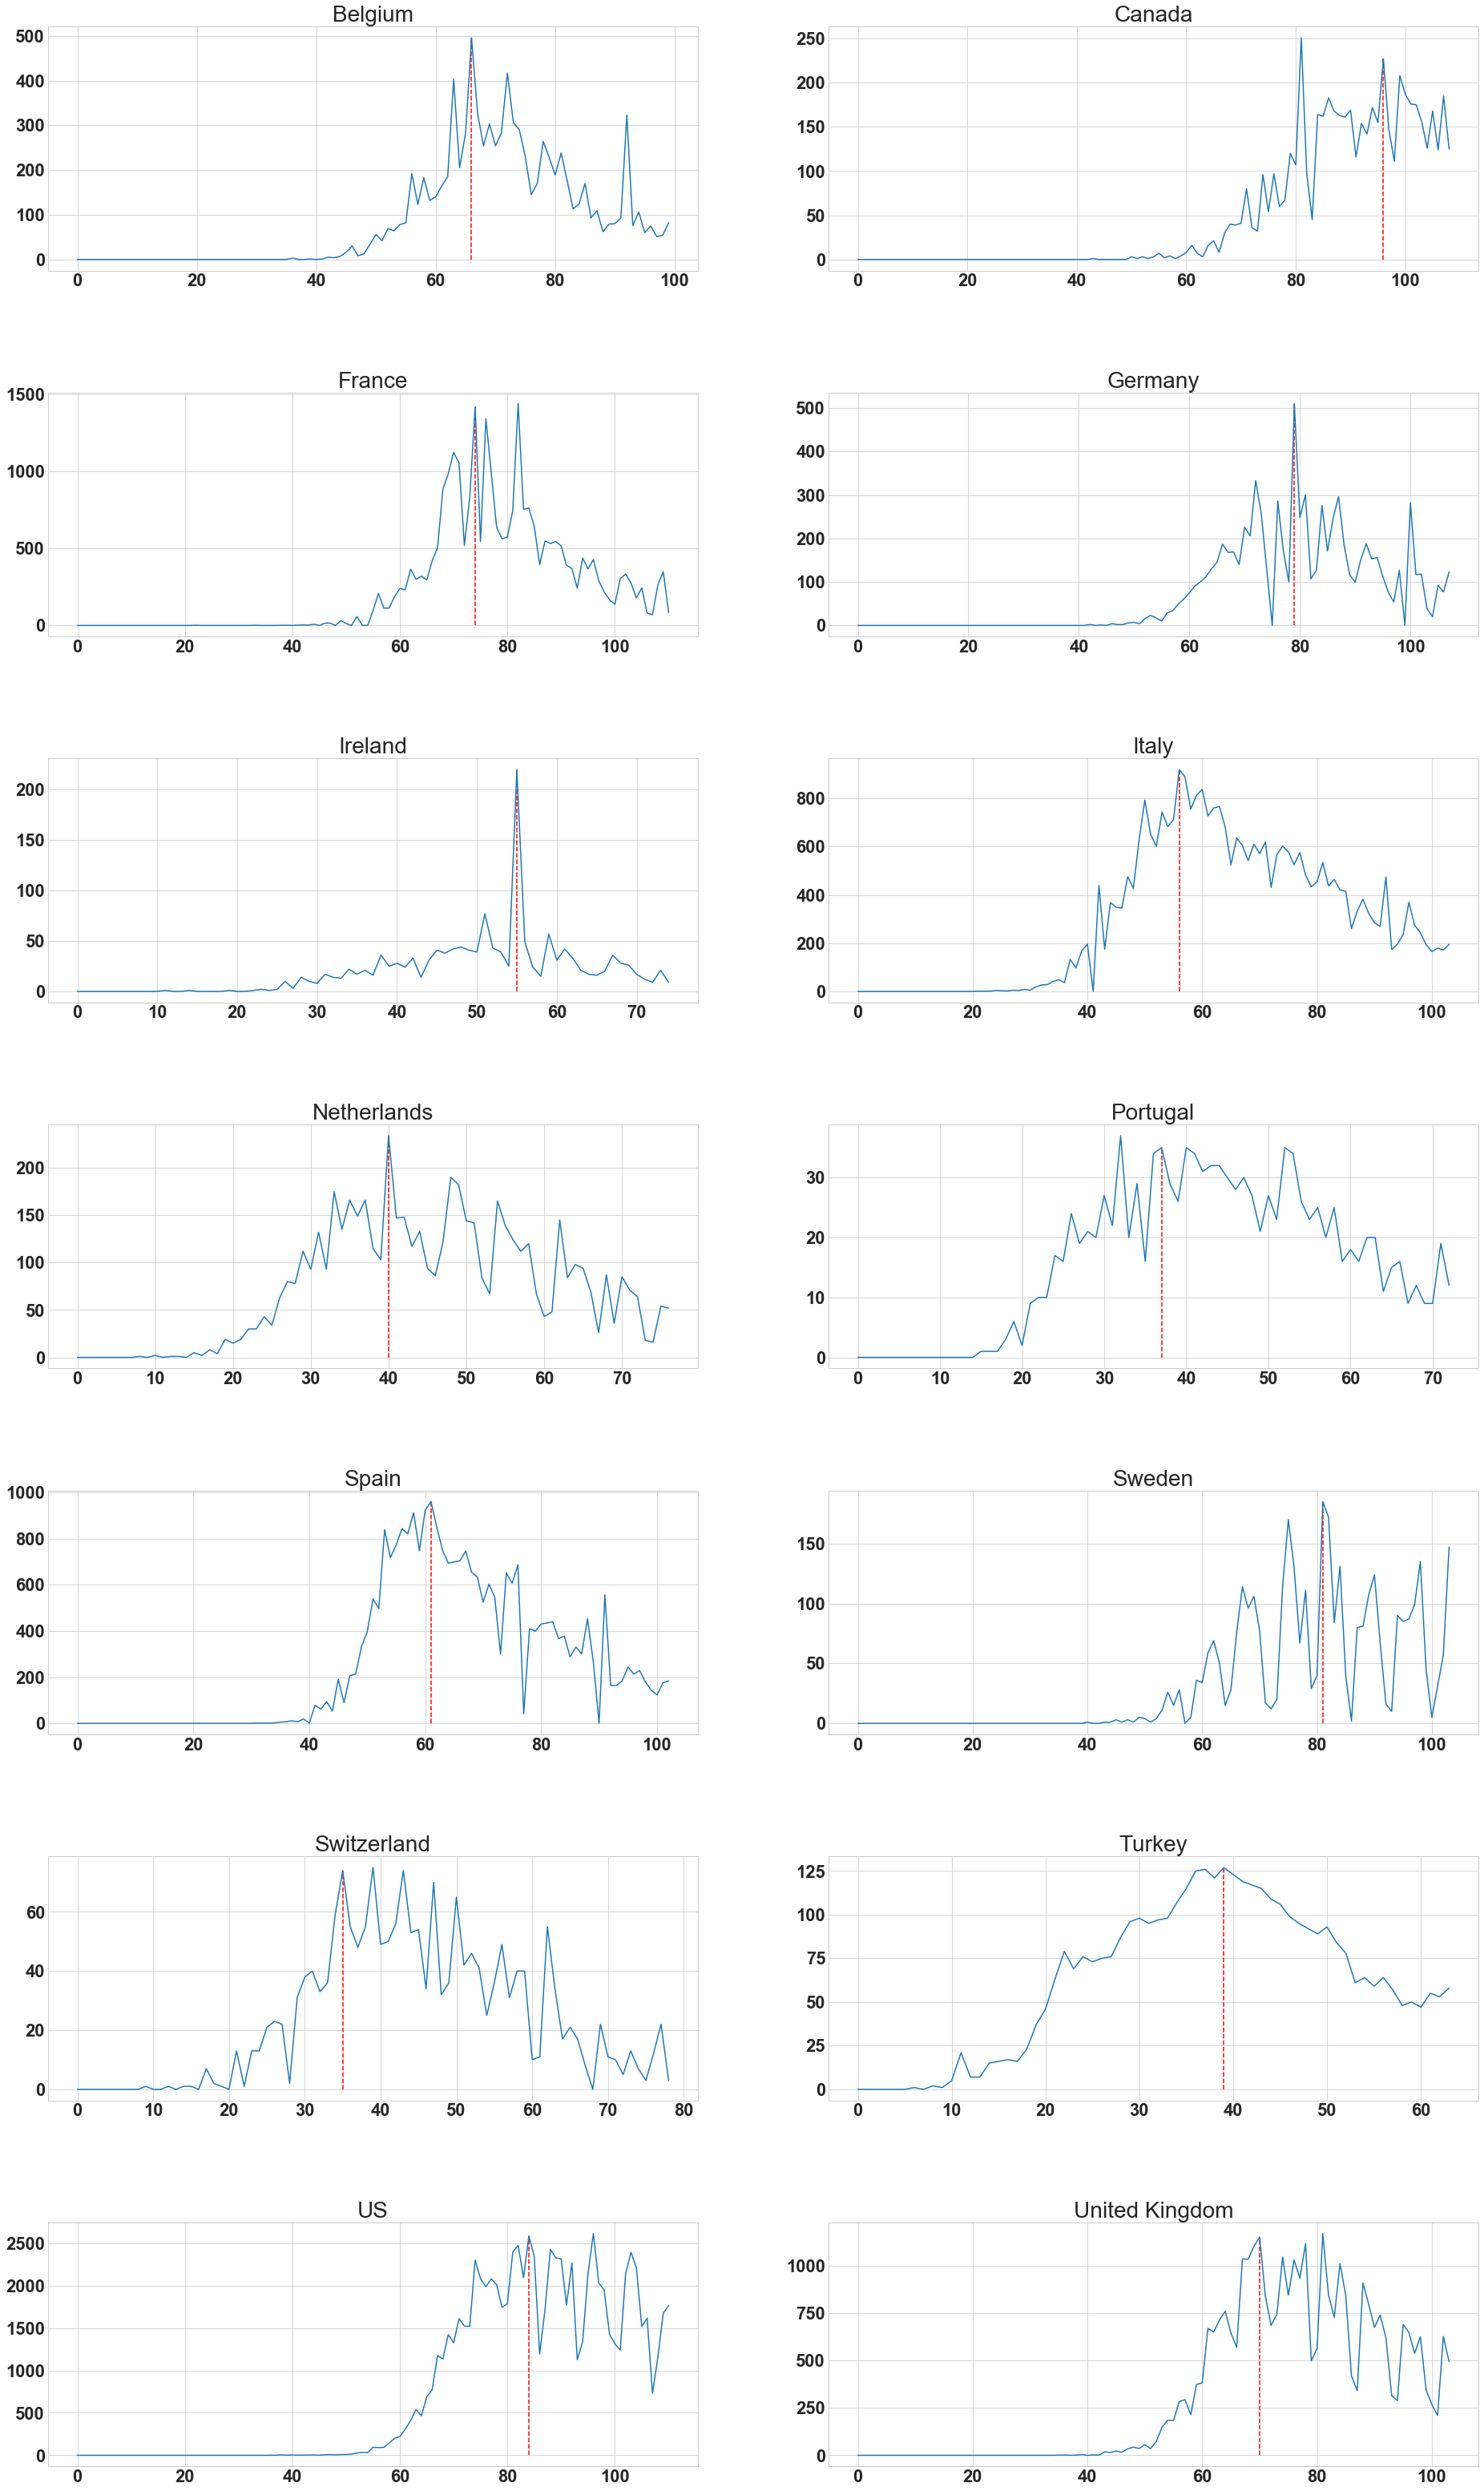

In [440]:
plot_peaks(selected_regions)